In [101]:
import os 
import math
import numpy as np
import pandas as pd 
from tqdm import tqdm
import csv
from datetime import datetime
import time

In [2]:
# Set directory
base = 'D:/owl-data/simple phs/' # save simple phs files here
save_path = f'./data/' # result csv files will be saved here
season = ['2018', '2019', '2020']

match_map_stats = pd.read_csv(base+'match_map_stats.csv')

In [37]:
# get round play time
match_map_stats = pd.read_csv(base+'match_map_stats.csv')
'''
round play time 구했는데 이게 실제 datetime 기반으로 찍히는 데이터라 PP 시간도 포함된 데이터임. 정확한 round play time을 반영하는 값이 아님.
'''
# convert nan value
match_map_stats['round_start_time'].fillna('2019-04-27 16:32:00', inplace=True) # there is one NULL values in 'round_start_time' so convert it to randomly chosen datetime. this is irrelevant when calculating DI because round time of winner and loser were same (control map)

round_start_time = pd.to_datetime(match_map_stats['round_start_time'])
round_end_time = pd.to_datetime(match_map_stats['round_end_time'])
round_play_time = round_end_time - round_start_time
round_play_time = round_play_time.dt.total_seconds()

match_map_stats['round_play_time'] = round_play_time

display(match_map_stats)

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score,round_play_time
0,2018-01-11 00:12:07,2018-01-11 00:20:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,...,San Francisco Shock,75.615051,0.000000,0.000000,240.000000,NaN,NaN,2,0,480.0
1,2018-01-11 00:22:05,2018-01-11 00:27:59,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,...,San Francisco Shock,75.649597,75.615051,125.750572,0.000000,NaN,NaN,3,2,354.0
2,2018-01-11 00:34:39,2018-01-11 00:38:29,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,...,San Francisco Shock,0.000000,0.000000,250.492004,240.000000,NaN,NaN,2,0,230.0
3,2018-01-11 00:40:27,2018-01-11 00:44:41,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,...,San Francisco Shock,0.000000,0.000000,225.789032,250.492004,NaN,NaN,2,2,254.0
4,2018-01-11 00:46:09,2018-01-11 00:49:48,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,...,San Francisco Shock,0.000000,0.000000,36.396057,250.492004,NaN,NaN,4,2,219.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9102,2020-10-10 14:42:51,2020-10-10 14:47:11,OWL 2020 Regular Season,35552,4,San Francisco Shock,Seoul Dynasty,San Francisco Shock,Watchpoint: Gibraltar,2,...,Seoul Dynasty,73.462471,88.701904,0.000000,18.485001,NaN,NaN,0,3,260.0
9103,2020-10-10 14:53:49,2020-10-10 14:59:07,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,1,...,San Francisco Shock,0.000000,0.000000,0.000000,0.000000,99.0,100.0,0,1,318.0
9104,2020-10-10 14:59:52,2020-10-10 15:05:13,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,2,...,San Francisco Shock,0.000000,0.000000,0.000000,0.000000,99.0,100.0,0,2,321.0
9105,2020-10-10 15:21:25,2020-10-10 15:31:23,OWL 2020 Regular Season,35552,6,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Hollywood,1,...,San Francisco Shock,74.363846,0.000000,0.000000,0.000000,NaN,NaN,2,0,598.0


In [43]:
# define map_type_dict to mapping map types
map_type_dict = {
    'Dorado':'Payload',
    'Temple of Anubis':'Assault',
    'Ilios':'Control',
    'Numbani':'Hybrid',
    'Eichenwalde':'Hybrid',
    'Junkertown':'Payload',
    'Oasis':'Control',
    'Horizon Lunar Colony':'Assault',
    'Lijiang Tower':'Control',
    'Volskaya Industries':'Assault',
    'Nepal':'Control',
    "King's Row":'Hybrid',
    'Route 66':'Payload',
    'Hollywood':'Hybrid',
    'Hanamura':'Assault',
    'Watchpoint: Gibraltar':'Payload',
    'Blizzard World':'Hybrid',
    'Rialto':'Payload',
    'Busan':'Control',
    'Paris':'Assault',
    'Havana':'Payload'
}
match_map_stats['map_type'] = match_map_stats['map_name'].map(map_type_dict)
display(match_map_stats)

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score,round_play_time,map_type
0,2018-01-11 00:12:07,2018-01-11 00:20:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,...,75.615051,0.000000,0.000000,240.000000,NaN,NaN,2,0,480.0,Payload
1,2018-01-11 00:22:05,2018-01-11 00:27:59,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,...,75.649597,75.615051,125.750572,0.000000,NaN,NaN,3,2,354.0,Payload
2,2018-01-11 00:34:39,2018-01-11 00:38:29,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,...,0.000000,0.000000,250.492004,240.000000,NaN,NaN,2,0,230.0,Assault
3,2018-01-11 00:40:27,2018-01-11 00:44:41,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,...,0.000000,0.000000,225.789032,250.492004,NaN,NaN,2,2,254.0,Assault
4,2018-01-11 00:46:09,2018-01-11 00:49:48,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,...,0.000000,0.000000,36.396057,250.492004,NaN,NaN,4,2,219.0,Assault
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9102,2020-10-10 14:42:51,2020-10-10 14:47:11,OWL 2020 Regular Season,35552,4,San Francisco Shock,Seoul Dynasty,San Francisco Shock,Watchpoint: Gibraltar,2,...,73.462471,88.701904,0.000000,18.485001,NaN,NaN,0,3,260.0,Payload
9103,2020-10-10 14:53:49,2020-10-10 14:59:07,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,1,...,0.000000,0.000000,0.000000,0.000000,99.0,100.0,0,1,318.0,Control
9104,2020-10-10 14:59:52,2020-10-10 15:05:13,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,2,...,0.000000,0.000000,0.000000,0.000000,99.0,100.0,0,2,321.0,Control
9105,2020-10-10 15:21:25,2020-10-10 15:31:23,OWL 2020 Regular Season,35552,6,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Hollywood,1,...,74.363846,0.000000,0.000000,0.000000,NaN,NaN,2,0,598.0,Hybrid


In [24]:
match_id_list = match_map_stats['match_id'].unique()
table = pd.DataFrame()

for match_ in tqdm(match_id_list):
    
    map_list = match_map_stats[match_map_stats['match_id'] == match_]['map_name'].unique()
    
    for map_ in map_list:
        df = match_map_stats[match_map_stats['match_id'] == match_]
        df = df[df['map_name'] == map_]

        if df['attacker_control_perecent'].isnull().values.any() == False: # Note that there is a typo 'perecent'
            is_ctrl = True
            team_one_time_played_attack = df['round_play_time'].sum()
            team_two_time_played_attack = df['round_play_time'].sum()

            if df['team_one_name'][df.index.values[0]] == df['attacker'][df.index.values[0]]:
                team_one_map_score = df['attacker_control_perecent'].sum() # Note that there is a typo 'perecent'
                team_two_map_score = df['defender_control_perecent'].sum()
            else:
                team_one_map_score = df['defender_control_perecent'].sum()
                team_two_map_score = df['attacker_control_perecent'].sum()

        else:
            is_ctrl = False
            team_one_time_played_attack = df[df['attacker']==df['team_one_name']]['round_play_time'].sum()
            team_two_time_played_attack = df[df['attacker']==df['team_two_name']]['round_play_time'].sum()
        
            if df['team_one_name'][df.index.values[0]] == df['map_winner'][df.index.values[0]]:
                team_one_map_score = df['winning_team_final_map_score'][df.index.values[0]]
                team_two_map_score = df['losing_team_final_map_score'][df.index.values[0]]
            else:
                team_one_map_score = df['losing_team_final_map_score'][df.index.values[0]]
                team_two_map_score = df['winning_team_final_map_score'][df.index.values[0]]
        
        team_one_score_per_time = team_one_map_score / team_one_time_played_attack
        team_two_score_per_time = team_two_map_score / team_two_time_played_attack

        team_one_DI = team_one_score_per_time / (team_one_score_per_time + team_two_score_per_time)
        team_two_DI = team_two_score_per_time / (team_one_score_per_time + team_two_score_per_time)

        df['team_one_DI'] = team_one_DI
        df['team_two_DI'] = team_two_DI
        
        table = pd.concat([table, df])

100%|██████████| 881/881 [00:25<00:00, 34.30it/s]


In [25]:
display(table)

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score,round_play_time,team_one_DI,team_two_DI
0,2018-01-11 00:12:07,2018-01-11 00:20:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,...,0.000000,0.000000,240.000000,NaN,NaN,2,0,480.0,0.670391,0.329609
1,2018-01-11 00:22:05,2018-01-11 00:27:59,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,...,75.615051,125.750572,0.000000,NaN,NaN,3,2,354.0,0.670391,0.329609
2,2018-01-11 00:34:39,2018-01-11 00:38:29,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,...,0.000000,250.492004,240.000000,NaN,NaN,2,0,230.0,0.615968,0.384032
3,2018-01-11 00:40:27,2018-01-11 00:44:41,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,...,0.000000,225.789032,250.492004,NaN,NaN,2,2,254.0,0.615968,0.384032
4,2018-01-11 00:46:09,2018-01-11 00:49:48,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,...,0.000000,36.396057,250.492004,NaN,NaN,4,2,219.0,0.615968,0.384032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9102,2020-10-10 14:42:51,2020-10-10 14:47:11,OWL 2020 Regular Season,35552,4,San Francisco Shock,Seoul Dynasty,San Francisco Shock,Watchpoint: Gibraltar,2,...,88.701904,0.000000,18.485001,NaN,NaN,0,3,260.0,0.000000,1.000000
9103,2020-10-10 14:53:49,2020-10-10 14:59:07,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,1,...,0.000000,0.000000,0.000000,99.0,100.0,0,1,318.0,0.497487,0.502513
9104,2020-10-10 14:59:52,2020-10-10 15:05:13,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,2,...,0.000000,0.000000,0.000000,99.0,100.0,0,2,321.0,0.497487,0.502513
9105,2020-10-10 15:21:25,2020-10-10 15:31:23,OWL 2020 Regular Season,35552,6,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Hollywood,1,...,0.000000,0.000000,0.000000,NaN,NaN,2,0,598.0,0.421127,0.578873


(array([709.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   2.,   8.,   4.,
          2.,  12.,  26.,  22.,  15.,  54.,  34.,  52.,  42.,  41.,  48.,
         58.,  60.,  73., 108., 104., 101.,  86.,  90.,  91.,  81., 161.,
        145., 128., 133., 154., 160., 177., 249., 234., 202., 176., 167.,
        132., 111., 134., 101., 173., 215., 252., 140., 120., 113., 109.,
        121., 163., 109., 129., 170., 146., 126., 121., 100., 132., 103.,
        155., 128., 115., 119.,  92.,  94.,  84.,  86.,  85.,  45.,  68.,
         58.,  42.,  54.,  40.,  48.,  48.,  44.,  36.,  20.,  37.,   6.,
         14.,   4.,   4.,   6.,   6.,   4.,   2.,   0.,   4.,   0.,   0.,
        524.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

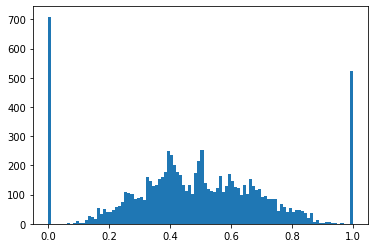

In [32]:
from matplotlib import pyplot as plt 

plt.hist(table['team_one_DI'], bins=100)

(0.0, 10.0)

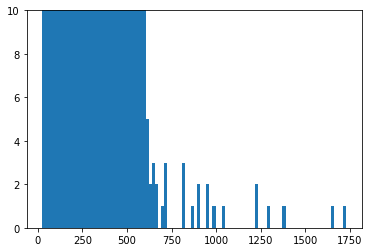

In [35]:
plt.hist(table['round_play_time'],bins=100)
plt.ylim(0,10)

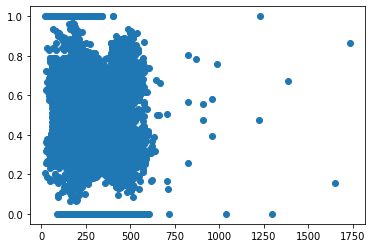

In [33]:
plt.scatter(x=table['round_play_time'], y=table['team_one_DI'])

# Reevaluate with Score difference / Time Played

In [ ]:
'''
Dominance Index
Control: (score diff/100) / Time Played
Hybrid/Payload: (score diff/3) / Time Played
Assault: (score diff/2) / Time Played
'''

In [46]:
# get round play time
match_map_stats = pd.read_csv(base+'match_map_stats.csv')
'''
round play time 구했는데 이게 실제 datetime 기반으로 찍히는 데이터라 PP 시간도 포함된 데이터임. 정확한 round play time을 반영하는 값이 아님.
'''
# convert nan value
match_map_stats['round_start_time'].fillna('2019-04-27 16:32:00', inplace=True) # there is one NULL values in 'round_start_time' so convert it to randomly chosen datetime. this is irrelevant when calculating DI because round time of winner and loser were same (control map)

round_start_time = pd.to_datetime(match_map_stats['round_start_time'])
round_end_time = pd.to_datetime(match_map_stats['round_end_time'])
round_play_time = round_end_time - round_start_time
round_play_time = round_play_time.dt.total_seconds()

match_map_stats['round_play_time'] = round_play_time

display(match_map_stats)

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score,round_play_time
0,2018-01-11 00:12:07,2018-01-11 00:20:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,...,San Francisco Shock,75.615051,0.000000,0.000000,240.000000,NaN,NaN,2,0,480.0
1,2018-01-11 00:22:05,2018-01-11 00:27:59,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,...,San Francisco Shock,75.649597,75.615051,125.750572,0.000000,NaN,NaN,3,2,354.0
2,2018-01-11 00:34:39,2018-01-11 00:38:29,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,...,San Francisco Shock,0.000000,0.000000,250.492004,240.000000,NaN,NaN,2,0,230.0
3,2018-01-11 00:40:27,2018-01-11 00:44:41,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,...,San Francisco Shock,0.000000,0.000000,225.789032,250.492004,NaN,NaN,2,2,254.0
4,2018-01-11 00:46:09,2018-01-11 00:49:48,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,...,San Francisco Shock,0.000000,0.000000,36.396057,250.492004,NaN,NaN,4,2,219.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9102,2020-10-10 14:42:51,2020-10-10 14:47:11,OWL 2020 Regular Season,35552,4,San Francisco Shock,Seoul Dynasty,San Francisco Shock,Watchpoint: Gibraltar,2,...,Seoul Dynasty,73.462471,88.701904,0.000000,18.485001,NaN,NaN,0,3,260.0
9103,2020-10-10 14:53:49,2020-10-10 14:59:07,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,1,...,San Francisco Shock,0.000000,0.000000,0.000000,0.000000,99.0,100.0,0,1,318.0
9104,2020-10-10 14:59:52,2020-10-10 15:05:13,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,2,...,San Francisco Shock,0.000000,0.000000,0.000000,0.000000,99.0,100.0,0,2,321.0
9105,2020-10-10 15:21:25,2020-10-10 15:31:23,OWL 2020 Regular Season,35552,6,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Hollywood,1,...,San Francisco Shock,74.363846,0.000000,0.000000,0.000000,NaN,NaN,2,0,598.0


In [47]:
# define map_type_dict to mapping map types
map_type_dict = {
    'Dorado':'Payload',
    'Temple of Anubis':'Assault',
    'Ilios':'Control',
    'Numbani':'Hybrid',
    'Eichenwalde':'Hybrid',
    'Junkertown':'Payload',
    'Oasis':'Control',
    'Horizon Lunar Colony':'Assault',
    'Lijiang Tower':'Control',
    'Volskaya Industries':'Assault',
    'Nepal':'Control',
    "King's Row":'Hybrid',
    'Route 66':'Payload',
    'Hollywood':'Hybrid',
    'Hanamura':'Assault',
    'Watchpoint: Gibraltar':'Payload',
    'Blizzard World':'Hybrid',
    'Rialto':'Payload',
    'Busan':'Control',
    'Paris':'Assault',
    'Havana':'Payload'
}
match_map_stats['map_type'] = match_map_stats['map_name'].map(map_type_dict)
display(match_map_stats)

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score,round_play_time,map_type
0,2018-01-11 00:12:07,2018-01-11 00:20:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,...,75.615051,0.000000,0.000000,240.000000,NaN,NaN,2,0,480.0,Payload
1,2018-01-11 00:22:05,2018-01-11 00:27:59,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,...,75.649597,75.615051,125.750572,0.000000,NaN,NaN,3,2,354.0,Payload
2,2018-01-11 00:34:39,2018-01-11 00:38:29,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,...,0.000000,0.000000,250.492004,240.000000,NaN,NaN,2,0,230.0,Assault
3,2018-01-11 00:40:27,2018-01-11 00:44:41,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,...,0.000000,0.000000,225.789032,250.492004,NaN,NaN,2,2,254.0,Assault
4,2018-01-11 00:46:09,2018-01-11 00:49:48,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,...,0.000000,0.000000,36.396057,250.492004,NaN,NaN,4,2,219.0,Assault
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9102,2020-10-10 14:42:51,2020-10-10 14:47:11,OWL 2020 Regular Season,35552,4,San Francisco Shock,Seoul Dynasty,San Francisco Shock,Watchpoint: Gibraltar,2,...,73.462471,88.701904,0.000000,18.485001,NaN,NaN,0,3,260.0,Payload
9103,2020-10-10 14:53:49,2020-10-10 14:59:07,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,1,...,0.000000,0.000000,0.000000,0.000000,99.0,100.0,0,1,318.0,Control
9104,2020-10-10 14:59:52,2020-10-10 15:05:13,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,2,...,0.000000,0.000000,0.000000,0.000000,99.0,100.0,0,2,321.0,Control
9105,2020-10-10 15:21:25,2020-10-10 15:31:23,OWL 2020 Regular Season,35552,6,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Hollywood,1,...,74.363846,0.000000,0.000000,0.000000,NaN,NaN,2,0,598.0,Hybrid


In [77]:
match_id_list = match_map_stats['match_id'].unique()
table = pd.DataFrame()

for match_ in tqdm(match_id_list):
    
    map_list = match_map_stats[match_map_stats['match_id'] == match_]['map_name'].unique()
    
    for map_ in map_list:
        df = match_map_stats[match_map_stats['match_id'] == match_]
        df = df[df['map_name'] == map_]

        if df['map_type'][df.index.values[0]] == 'Control': # Note that there is a typo 'perecent'
            team_one_time_played_attack = df['round_play_time'].sum()
            team_two_time_played_attack = df['round_play_time'].sum()

            if df['team_one_name'][df.index.values[0]] == df['attacker'][df.index.values[0]]:
                team_one_map_score = df['attacker_control_perecent'].sum() # Note that there is a typo 'perecent'
                team_two_map_score = df['defender_control_perecent'].sum()
                
            else:
                team_one_map_score = df['defender_control_perecent'].sum()
                team_two_map_score = df['attacker_control_perecent'].sum()
            
            team_one_DI = ((team_one_map_score - team_two_map_score)/100) / team_one_time_played_attack
            team_two_DI = ((team_two_map_score - team_one_map_score)/100) / team_two_time_played_attack

        elif df['map_type'][df.index.values[0]] == 'Hybrid':
            team_one_time_played_attack = df[df['attacker']==df['team_one_name']]['round_play_time'].sum()
            team_two_time_played_attack = df[df['attacker']==df['team_two_name']]['round_play_time'].sum()
        
            if df['team_one_name'][df.index.values[0]] == df['map_winner'][df.index.values[0]]:
                team_one_map_score = df['winning_team_final_map_score'][df.index.values[0]]
                team_two_map_score = df['losing_team_final_map_score'][df.index.values[0]]
            else:
                team_one_map_score = df['losing_team_final_map_score'][df.index.values[0]]
                team_two_map_score = df['winning_team_final_map_score'][df.index.values[0]]
            
            team_one_DI = ((team_one_map_score - team_two_map_score)/3) / team_one_time_played_attack
            team_two_DI = ((team_two_map_score - team_one_map_score)/3) / team_two_time_played_attack
        
        elif df['map_type'][df.index.values[0]] == 'Payload':
            team_one_time_played_attack = df[df['attacker']==df['team_one_name']]['round_play_time'].sum()
            team_two_time_played_attack = df[df['attacker']==df['team_two_name']]['round_play_time'].sum()
        
            if df['team_one_name'][df.index.values[0]] == df['map_winner'][df.index.values[0]]:
                team_one_map_score = df['winning_team_final_map_score'][df.index.values[0]]
                team_two_map_score = df['losing_team_final_map_score'][df.index.values[0]]
            else:
                team_one_map_score = df['losing_team_final_map_score'][df.index.values[0]]
                team_two_map_score = df['winning_team_final_map_score'][df.index.values[0]]
            
            team_one_DI = ((team_one_map_score - team_two_map_score)/3) / team_one_time_played_attack
            team_two_DI = ((team_two_map_score - team_one_map_score)/3) / team_two_time_played_attack

        elif df['map_type'][df.index.values[0]] == 'Assault':
            team_one_time_played_attack = df[df['attacker']==df['team_one_name']]['round_play_time'].sum()
            team_two_time_played_attack = df[df['attacker']==df['team_two_name']]['round_play_time'].sum()
        
            if df['team_one_name'][df.index.values[0]] == df['map_winner'][df.index.values[0]]:
                team_one_map_score = df['winning_team_final_map_score'][df.index.values[0]]
                team_two_map_score = df['losing_team_final_map_score'][df.index.values[0]]
            else:
                team_one_map_score = df['losing_team_final_map_score'][df.index.values[0]]
                team_two_map_score = df['winning_team_final_map_score'][df.index.values[0]]
            
            team_one_DI = ((team_one_map_score - team_two_map_score)/2) / team_one_time_played_attack
            team_two_DI = ((team_two_map_score - team_one_map_score)/2) / team_two_time_played_attack

        df['team_one_DI'] = team_one_DI
        df['team_two_DI'] = team_two_DI
        
        table = pd.concat([table, df])

100%|██████████| 881/881 [00:27<00:00, 32.41it/s]


In [78]:
display(table)

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score,round_play_time,map_type,team_one_DI,team_two_DI
0,2018-01-11 00:12:07,2018-01-11 00:20:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,...,0.000000,240.000000,NaN,NaN,2,0,480.0,Payload,0.000942,-0.000694
1,2018-01-11 00:22:05,2018-01-11 00:27:59,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,...,125.750572,0.000000,NaN,NaN,3,2,354.0,Payload,0.000942,-0.000694
2,2018-01-11 00:34:39,2018-01-11 00:38:29,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,...,250.492004,240.000000,NaN,NaN,2,0,230.0,Assault,0.001057,-0.000879
3,2018-01-11 00:40:27,2018-01-11 00:44:41,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,...,225.789032,250.492004,NaN,NaN,2,2,254.0,Assault,0.001057,-0.000879
4,2018-01-11 00:46:09,2018-01-11 00:49:48,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,...,36.396057,250.492004,NaN,NaN,4,2,219.0,Assault,0.001057,-0.000879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9102,2020-10-10 14:42:51,2020-10-10 14:47:11,OWL 2020 Regular Season,35552,4,San Francisco Shock,Seoul Dynasty,San Francisco Shock,Watchpoint: Gibraltar,2,...,0.000000,18.485001,NaN,NaN,0,3,260.0,Payload,-0.003846,0.002160
9103,2020-10-10 14:53:49,2020-10-10 14:59:07,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,1,...,0.000000,0.000000,99.0,100.0,0,1,318.0,Control,-0.000031,0.000031
9104,2020-10-10 14:59:52,2020-10-10 15:05:13,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,2,...,0.000000,0.000000,99.0,100.0,0,2,321.0,Control,-0.000031,0.000031
9105,2020-10-10 15:21:25,2020-10-10 15:31:23,OWL 2020 Regular Season,35552,6,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Hollywood,1,...,0.000000,0.000000,NaN,NaN,2,0,598.0,Hybrid,-0.000811,0.000557


<AxesSubplot:xlabel='team_two_DI', ylabel='Count'>

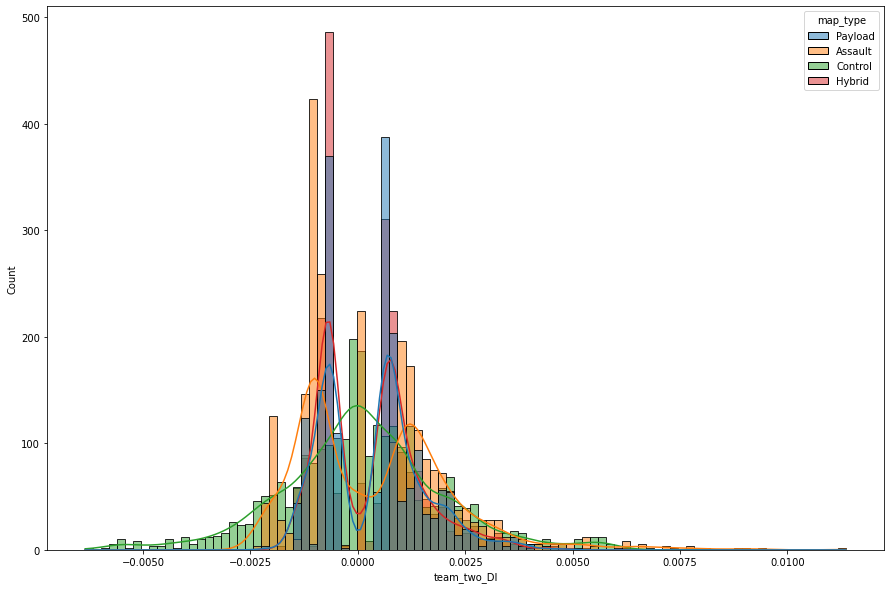

In [79]:
import seaborn as sns

# plt.hist(table[table['map_type']=='Control']['team_one_DI'], bins=100, color='r')
fig, ax = plt.subplots(figsize=(15,10))
# sns.histplot(data=table, x='team_one_DI', kde=True, hue='map_type', ax=ax)
sns.histplot(data=table, x='team_two_DI', kde=True, hue='map_type', ax=ax)

# Reevaluate with payload score + time banked

In [86]:
'''
final_score = score + additional score
winner's additional score = score * (time banked / time played) -> 추가 시간을 남겼다면 지금까지 플레이한 시간 비례로 선형적으로 더 점수를 딴다고 가정

<Score definition>

Control: %control
Hybrid: Payload distance (거점 점수는 각 맵별로 환산된 payload distance)
Payload: Payload distance
Assault: point
'''

In [104]:
# get round play time
match_map_stats = pd.read_csv(base+'match_map_stats.csv')
'''
round play time 구했는데 이게 실제 datetime 기반으로 찍히는 데이터라 PP 시간도 포함된 데이터임. 정확한 round play time을 반영하는 값이 아님.
'''
# convert nan value
match_map_stats['round_start_time'].fillna('2019-04-27 16:32:00', inplace=True) # there is one NULL values in 'round_start_time' so convert it to randomly chosen datetime. this is irrelevant when calculating DI because round time of winner and loser were same (control map)

round_start_time = pd.to_datetime(match_map_stats['round_start_time'])
round_end_time = pd.to_datetime(match_map_stats['round_end_time'])
round_play_time = round_end_time - round_start_time
round_play_time = round_play_time.dt.total_seconds()

match_map_stats['round_play_time'] = round_play_time

display(match_map_stats)

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score,round_play_time
0,2018-01-11 00:12:07,2018-01-11 00:20:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,...,San Francisco Shock,75.615051,0.000000,0.000000,240.000000,NaN,NaN,2,0,480.0
1,2018-01-11 00:22:05,2018-01-11 00:27:59,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,...,San Francisco Shock,75.649597,75.615051,125.750572,0.000000,NaN,NaN,3,2,354.0
2,2018-01-11 00:34:39,2018-01-11 00:38:29,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,...,San Francisco Shock,0.000000,0.000000,250.492004,240.000000,NaN,NaN,2,0,230.0
3,2018-01-11 00:40:27,2018-01-11 00:44:41,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,...,San Francisco Shock,0.000000,0.000000,225.789032,250.492004,NaN,NaN,2,2,254.0
4,2018-01-11 00:46:09,2018-01-11 00:49:48,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,...,San Francisco Shock,0.000000,0.000000,36.396057,250.492004,NaN,NaN,4,2,219.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9102,2020-10-10 14:42:51,2020-10-10 14:47:11,OWL 2020 Regular Season,35552,4,San Francisco Shock,Seoul Dynasty,San Francisco Shock,Watchpoint: Gibraltar,2,...,Seoul Dynasty,73.462471,88.701904,0.000000,18.485001,NaN,NaN,0,3,260.0
9103,2020-10-10 14:53:49,2020-10-10 14:59:07,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,1,...,San Francisco Shock,0.000000,0.000000,0.000000,0.000000,99.0,100.0,0,1,318.0
9104,2020-10-10 14:59:52,2020-10-10 15:05:13,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,2,...,San Francisco Shock,0.000000,0.000000,0.000000,0.000000,99.0,100.0,0,2,321.0
9105,2020-10-10 15:21:25,2020-10-10 15:31:23,OWL 2020 Regular Season,35552,6,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Hollywood,1,...,San Francisco Shock,74.363846,0.000000,0.000000,0.000000,NaN,NaN,2,0,598.0


In [105]:
# define map_type_dict to mapping map types
map_type_dict = {
    'Dorado':'Payload',
    'Temple of Anubis':'Assault',
    'Ilios':'Control',
    'Numbani':'Hybrid',
    'Eichenwalde':'Hybrid',
    'Junkertown':'Payload',
    'Oasis':'Control',
    'Horizon Lunar Colony':'Assault',
    'Lijiang Tower':'Control',
    'Volskaya Industries':'Assault',
    'Nepal':'Control',
    "King's Row":'Hybrid',
    'Route 66':'Payload',
    'Hollywood':'Hybrid',
    'Hanamura':'Assault',
    'Watchpoint: Gibraltar':'Payload',
    'Blizzard World':'Hybrid',
    'Rialto':'Payload',
    'Busan':'Control',
    'Paris':'Assault',
    'Havana':'Payload'
}
match_map_stats['map_type'] = match_map_stats['map_name'].map(map_type_dict)
display(match_map_stats)

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score,round_play_time,map_type
0,2018-01-11 00:12:07,2018-01-11 00:20:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,...,75.615051,0.000000,0.000000,240.000000,NaN,NaN,2,0,480.0,Payload
1,2018-01-11 00:22:05,2018-01-11 00:27:59,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,...,75.649597,75.615051,125.750572,0.000000,NaN,NaN,3,2,354.0,Payload
2,2018-01-11 00:34:39,2018-01-11 00:38:29,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,...,0.000000,0.000000,250.492004,240.000000,NaN,NaN,2,0,230.0,Assault
3,2018-01-11 00:40:27,2018-01-11 00:44:41,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,...,0.000000,0.000000,225.789032,250.492004,NaN,NaN,2,2,254.0,Assault
4,2018-01-11 00:46:09,2018-01-11 00:49:48,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,...,0.000000,0.000000,36.396057,250.492004,NaN,NaN,4,2,219.0,Assault
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9102,2020-10-10 14:42:51,2020-10-10 14:47:11,OWL 2020 Regular Season,35552,4,San Francisco Shock,Seoul Dynasty,San Francisco Shock,Watchpoint: Gibraltar,2,...,73.462471,88.701904,0.000000,18.485001,NaN,NaN,0,3,260.0,Payload
9103,2020-10-10 14:53:49,2020-10-10 14:59:07,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,1,...,0.000000,0.000000,0.000000,0.000000,99.0,100.0,0,1,318.0,Control
9104,2020-10-10 14:59:52,2020-10-10 15:05:13,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,2,...,0.000000,0.000000,0.000000,0.000000,99.0,100.0,0,2,321.0,Control
9105,2020-10-10 15:21:25,2020-10-10 15:31:23,OWL 2020 Regular Season,35552,6,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Hollywood,1,...,74.363846,0.000000,0.000000,0.000000,NaN,NaN,2,0,598.0,Hybrid


In [106]:
payload_distance_dict = {
    'Dorado':[87, 96, 85.58],
    'Temple of Anubis':[100, 100],
    'Ilios':[100, 100, 100],
    'Numbani':[96.5, 71.55],
    'Eichenwalde':[128, 67.5],
    'Junkertown':[91.3, 86, 101.66],
    'Oasis':[100, 100, 100],
    'Horizon Lunar Colony':[100, 100],
    'Lijiang Tower':[100, 100, 100],
    'Volskaya Industries':[100, 100],
    'Nepal':[100, 100, 100],
    "King's Row":[114.6, 70.04],
    'Route 66':[85, 92, 74.38],
    'Hollywood':[119.4, 78.9],
    'Hanamura':[100, 100],
    'Watchpoint: Gibraltar':[85.6, 82.5, 88.47],
    'Blizzard World':[114, 111.35],
    'Rialto':[97, 104.6, 87.9],
    'Busan':[100, 100, 100],
    'Paris':[100, 100],
    'Havana':[88, 92.6, 103.18]
}
match_map_stats['map_payload_distance'] = match_map_stats['map_name'].map(payload_distance_dict)

def first_point_value(list_): # calculate the values of the first points of the hybrid maps
    return np.mean(list_)

match_map_stats['hybrid_first_point_value'] = match_map_stats[match_map_stats['map_type'] == 'Hybrid']['map_payload_distance'].apply(first_point_value)

display(match_map_stats)

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score,round_play_time,map_type,map_payload_distance,hybrid_first_point_value
0,2018-01-11 00:12:07,2018-01-11 00:20:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,...,0.000000,240.000000,NaN,NaN,2,0,480.0,Payload,"[87, 96, 85.58]",NaN
1,2018-01-11 00:22:05,2018-01-11 00:27:59,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,...,125.750572,0.000000,NaN,NaN,3,2,354.0,Payload,"[87, 96, 85.58]",NaN
2,2018-01-11 00:34:39,2018-01-11 00:38:29,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,...,250.492004,240.000000,NaN,NaN,2,0,230.0,Assault,"[100, 100]",NaN
3,2018-01-11 00:40:27,2018-01-11 00:44:41,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,...,225.789032,250.492004,NaN,NaN,2,2,254.0,Assault,"[100, 100]",NaN
4,2018-01-11 00:46:09,2018-01-11 00:49:48,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,...,36.396057,250.492004,NaN,NaN,4,2,219.0,Assault,"[100, 100]",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9102,2020-10-10 14:42:51,2020-10-10 14:47:11,OWL 2020 Regular Season,35552,4,San Francisco Shock,Seoul Dynasty,San Francisco Shock,Watchpoint: Gibraltar,2,...,0.000000,18.485001,NaN,NaN,0,3,260.0,Payload,"[85.6, 82.5, 88.47]",NaN
9103,2020-10-10 14:53:49,2020-10-10 14:59:07,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,1,...,0.000000,0.000000,99.0,100.0,0,1,318.0,Control,"[100, 100, 100]",NaN
9104,2020-10-10 14:59:52,2020-10-10 15:05:13,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,2,...,0.000000,0.000000,99.0,100.0,0,2,321.0,Control,"[100, 100, 100]",NaN
9105,2020-10-10 15:21:25,2020-10-10 15:31:23,OWL 2020 Regular Season,35552,6,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Hollywood,1,...,0.000000,0.000000,NaN,NaN,2,0,598.0,Hybrid,"[119.4, 78.9]",99.15


In [120]:
match_id_list = match_map_stats['match_id'].unique()
table = pd.DataFrame()

base_score = 0 # give a base_score if '0' scores make deviation
num_first_point_taken = [0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4] # score 별 첫 거점 획득 횟수

for match_ in tqdm(match_id_list):
    
    map_list = match_map_stats[match_map_stats['match_id'] == match_]['map_name'].unique()
    
    for map_ in map_list:
        df = match_map_stats[match_map_stats['match_id'] == match_]
        df = df[df['map_name'] == map_]

        # Control
        if df['map_type'][df.index.values[0]] == 'Control': # Note that there is a typo 'perecent'

            if df['team_one_name'][df.index.values[0]] == df['attacker'][df.index.values[0]]:
                team_one_map_score = df['attacker_control_perecent'].sum() # Note that there is a typo 'perecent'
                team_two_map_score = df['defender_control_perecent'].sum()
                
            else:
                team_one_map_score = df['defender_control_perecent'].sum()
                team_two_map_score = df['attacker_control_perecent'].sum()
            
            team_one_map_score = (team_one_map_score + base_score)
            team_two_map_score = (team_two_map_score + base_score)

        # Hybrid
        

        elif df['map_type'][df.index.values[0]] == 'Hybrid':
            team_one_time_played_attack = df[df['attacker']==df['team_one_name']]['round_play_time'].sum()
            team_two_time_played_attack = df[df['attacker']==df['team_two_name']]['round_play_time'].sum()
        
            if df['team_one_name'][df.index.values[0]] == df['map_winner'][df.index.values[0]]: # if team_one == map_winner
                # map_score = (point scored//3 + 1) * first_point_value + total payload distance
                team_one_map_score = (num_first_point_taken[df['winning_team_final_map_score'][df.index.values[0]]] * df['hybrid_first_point_value'][df.index.values[0]]) + df[df['attacker']==df['team_one_name']]['attacker_payload_distance'].sum()
                team_two_map_score = (num_first_point_taken[df['losing_team_final_map_score'][df.index.values[0]]] * df['hybrid_first_point_value'][df.index.values[0]]) + df[df['attacker']==df['team_two_name']]['attacker_payload_distance'].sum()
                # winner's additional score
                winners_time_banked = abs(df['attacker_time_banked'][df.index.values[-1]] - df['defender_time_banked'][df.index.values[-1]])
                winners_additional_score = team_one_map_score * (winners_time_banked / team_one_time_played_attack)
                team_one_map_score += winners_additional_score
            
            else: # team_two == map_winner or 'draw'
                # map_score = (point scored//3 + 1) * first_point_value + total payload distance
                team_one_map_score = (num_first_point_taken[df['losing_team_final_map_score'][df.index.values[0]]] * df['hybrid_first_point_value'][df.index.values[0]]) + df[df['attacker']==df['team_one_name']]['attacker_payload_distance'].sum()
                team_two_map_score = (num_first_point_taken[df['winning_team_final_map_score'][df.index.values[0]]] * df['hybrid_first_point_value'][df.index.values[0]]) + df[df['attacker']==df['team_two_name']]['attacker_payload_distance'].sum()
                # winner's additional score
                winners_time_banked = abs(df['attacker_time_banked'][df.index.values[-1]] - df['defender_time_banked'][df.index.values[-1]])
                winners_additional_score = team_two_map_score * (winners_time_banked / team_two_time_played_attack)
                team_two_map_score += winners_additional_score

            team_one_map_score = (team_one_map_score + base_score) 
            team_two_map_score = (team_two_map_score + base_score) 
        
        # Escort
        elif df['map_type'][df.index.values[0]] == 'Payload':
            team_one_time_played_attack = df[df['attacker']==df['team_one_name']]['round_play_time'].sum()
            team_two_time_played_attack = df[df['attacker']==df['team_two_name']]['round_play_time'].sum()
        
            if df['team_one_name'][df.index.values[0]] == df['map_winner'][df.index.values[0]]: # if team_one == map_winner
                # map_score = total payload distance
                team_one_map_score = df[df['attacker']==df['team_one_name']]['attacker_payload_distance'].sum()
                team_two_map_score = df[df['attacker']==df['team_two_name']]['attacker_payload_distance'].sum()
                # winner's additional score
                winners_time_banked = abs(df['attacker_time_banked'][df.index.values[-1]] - df['defender_time_banked'][df.index.values[-1]])
                winners_additional_score = team_one_map_score * (winners_time_banked / team_one_time_played_attack)
                team_one_map_score += winners_additional_score
            else: # team_two == map_winner or 'draw'
                # map_score = (point scored//3 + 1) * (df['map_payload_distance'].index.values[0]/3) + total payload distance
                team_one_map_score = df[df['attacker']==df['team_one_name']]['attacker_payload_distance'].sum()
                team_two_map_score = df[df['attacker']==df['team_two_name']]['attacker_payload_distance'].sum()
                # winner's additional score
                winners_time_banked = abs(df['attacker_time_banked'][df.index.values[-1]] - df['defender_time_banked'][df.index.values[-1]])
                winners_additional_score = team_two_map_score * (winners_time_banked / team_two_time_played_attack)
                team_two_map_score += winners_additional_score

            team_one_map_score = (team_one_map_score + base_score) 
            team_two_map_score = (team_two_map_score + base_score) 

        # 2CP
        elif df['map_type'][df.index.values[0]] == 'Assault':
            team_one_time_played_attack = df[df['attacker']==df['team_one_name']]['round_play_time'].sum()
            team_two_time_played_attack = df[df['attacker']==df['team_two_name']]['round_play_time'].sum()
        
            if df['team_one_name'][df.index.values[0]] == df['map_winner'][df.index.values[0]]: # if team_one == map_winner
                # map_score = final_map_score * 100 (100 / 1point)
                team_one_map_score = df['winning_team_final_map_score'][df.index.values[0]] * 100
                team_two_map_score = df['losing_team_final_map_score'][df.index.values[0]] * 100
                # winner's additional score
                winners_time_banked = abs(df['attacker_time_banked'][df.index.values[-1]] - df['defender_time_banked'][df.index.values[-1]])
                winners_additional_score = team_one_map_score * (winners_time_banked / team_one_time_played_attack)
                team_one_map_score += winners_additional_score
            else: # team_two == map_winner
                # map_score = final_map_score * 100 (100 / 1point)
                team_one_map_score = df['losing_team_final_map_score'][df.index.values[0]] * 100
                team_two_map_score = df['winning_team_final_map_score'][df.index.values[0]] * 100
                # winner's additional score
                winners_time_banked = abs(df['attacker_time_banked'][df.index.values[-1]] - df['defender_time_banked'][df.index.values[-1]])
                winners_additional_score = team_two_map_score * (winners_time_banked / team_two_time_played_attack)
                team_two_map_score += winners_additional_score

        df['team_one_map_score'] = team_one_map_score
        df['team_two_map_score'] = team_two_map_score
        df['team_one_DI'] = team_one_map_score / (team_one_map_score + team_two_map_score)
        df['team_two_DI'] = team_two_map_score / (team_one_map_score + team_two_map_score)
        
        table = pd.concat([table, df])

100%|██████████| 881/881 [00:36<00:00, 23.96it/s]


In [121]:
display(table)

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,attacker_round_end_score,defender_round_end_score,round_play_time,map_type,map_payload_distance,hybrid_first_point_value,team_one_map_score,team_two_map_score,team_one_DI,team_two_DI
0,2018-01-11 00:12:07,2018-01-11 00:20:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,...,2,0,480.0,Payload,"[87, 96, 85.58]",NaN,102.522422,75.615051,0.575524,0.424476
1,2018-01-11 00:22:05,2018-01-11 00:27:59,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,...,3,2,354.0,Payload,"[87, 96, 85.58]",NaN,102.522422,75.615051,0.575524,0.424476
2,2018-01-11 00:34:39,2018-01-11 00:38:29,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,...,2,0,230.0,Assault,"[100, 100]",NaN,430.778907,300.000000,0.589479,0.410521
3,2018-01-11 00:40:27,2018-01-11 00:44:41,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,...,2,2,254.0,Assault,"[100, 100]",NaN,430.778907,300.000000,0.589479,0.410521
4,2018-01-11 00:46:09,2018-01-11 00:49:48,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,...,4,2,219.0,Assault,"[100, 100]",NaN,430.778907,300.000000,0.589479,0.410521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9102,2020-10-10 14:42:51,2020-10-10 14:47:11,OWL 2020 Regular Season,35552,4,San Francisco Shock,Seoul Dynasty,San Francisco Shock,Watchpoint: Gibraltar,2,...,0,3,260.0,Payload,"[85.6, 82.5, 88.47]",NaN,73.462471,92.243275,0.443331,0.556669
9103,2020-10-10 14:53:49,2020-10-10 14:59:07,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,1,...,0,1,318.0,Control,"[100, 100, 100]",NaN,198.000000,200.000000,0.497487,0.502513
9104,2020-10-10 14:59:52,2020-10-10 15:05:13,OWL 2020 Regular Season,35552,5,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Busan,2,...,0,2,321.0,Control,"[100, 100, 100]",NaN,198.000000,200.000000,0.497487,0.502513
9105,2020-10-10 15:21:25,2020-10-10 15:31:23,OWL 2020 Regular Season,35552,6,San Francisco Shock,San Francisco Shock,Seoul Dynasty,Hollywood,1,...,2,0,598.0,Hybrid,"[119.4, 78.9]",99.15,156.968954,173.513846,0.474969,0.525031


<AxesSubplot:xlabel='team_two_DI', ylabel='Count'>

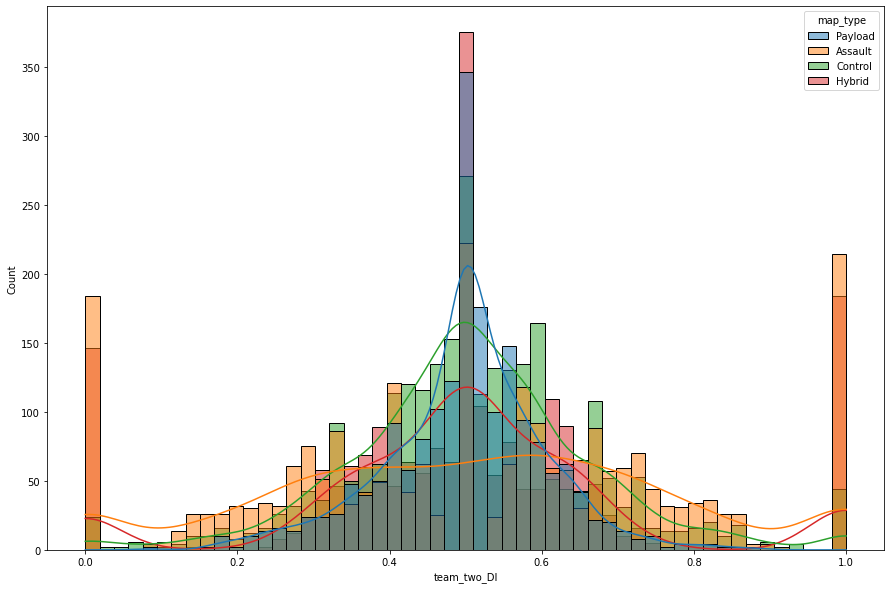

In [124]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(data=table, x='team_two_DI', kde=True, hue='map_type', ax=ax)

In [123]:
# save to csv
table.to_csv((save_path+'new_match_map_stats.csv'), index=False)

In [197]:
# Transform new_phs files
path = "./data/"
phs_list = os.listdir(path)
phs_list = [file_name for file_name in phs_list if file_name.endswith(".csv")]
phs_list = phs_list[1:] # remove new_match_map_stats.csv file

for file_name in tqdm(phs_list):
    csv = pd.read_csv(path + file_name)
    df_map = table[['match_id', 'map_name', 'team_one_name', 'team_two_name', 'team_one_map_score', 'team_two_map_score', 'team_one_DI', 'team_two_DI']]
    df_map = df_map.groupby(by=['match_id', 'map_name']).mean()
    df_map.reset_index(inplace=True)

    df = pd.merge(csv, df_map, how='left', left_on=['esports_match_id', 'map_name'], right_on=['match_id', 'map_name'])

    # add is_map_winner
    is_map_winner = (df['map_winner']==df['team_name'])
    is_map_winner = is_map_winner.map({True:1, False:0})
    df['is_map_winner'] = is_map_winner
    df['is_map_winner'][df['map_winner'] == 'draw'] = -1

    # save
    df.to_csv(path + file_name, index=False)

100%|██████████| 12/12 [01:26<00:00,  7.19s/it]
